In [1]:
!pip install cartopy

In [2]:
import pandas as pd

# Đường dẫn tới file CSV
CSV_PATH = "/kaggle/input/data-full-features-ai/weather_data_nghean (1).csv"

# Đọc dữ liệu từ file CSV
df = pd.read_csv(CSV_PATH)

# Kiểm tra cột 'Radar' có tồn tại không
if 'Radar' not in df.columns:
    raise ValueError("Cột 'Radar' không tồn tại trong dữ liệu!")

# Đếm số lượng giá trị Radar = 0 và Radar > 0
radar_zero = (df['Radar'] == 0).sum()
radar_positive = (df['Radar'] > 0).sum()

# In kết quả
print(f"Số lượng giá trị Radar = 0: {radar_zero}")
print(f"Số lượng giá trị Radar > 0: {radar_positive}")
print(f"Tổng số giá trị Radar: {radar_zero + radar_positive}")
print(f"Tỷ lệ không mưa (Radar = 0) / có mưa (Radar > 0): {radar_zero / radar_positive:.2f}" if radar_positive > 0 else "Không có giá trị Radar > 0")

Số lượng giá trị Radar = 0: 340650
Số lượng giá trị Radar > 0: 47843
Tổng số giá trị Radar: 388493
Tỷ lệ không mưa (Radar = 0) / có mưa (Radar > 0): 7.12


In [3]:
# Mô tả: Import các thư viện cần thiết cho xử lý dữ liệu, mô hình, và vẽ biểu đồ
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor


In [4]:
# Mô tả: Định nghĩa các đường dẫn, kích thước bản đồ, và tạo thư mục đầu ra
OUTPUT_PATH = "/kaggle/working/"
BEST_MODEL_PLOTS_PATH = os.path.join(OUTPUT_PATH, "best_model_plots")
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(BEST_MODEL_PLOTS_PATH, exist_ok=True)
CSV_PATH = "/kaggle/input/data-full-features-ai/weather_data_nghean (1).csv"
HEIGHT, WIDTH = 90, 250

In [5]:
# Mô tả: Đọc file CSV, chọn đặc trưng, xử lý NaN, thêm cột hour, và chia dữ liệu
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"File {CSV_PATH} không tồn tại!")

print("Đang đọc dữ liệu từ CSV...")
df = pd.read_csv(CSV_PATH)
if df.empty:
    raise ValueError("File CSV rỗng!")

exclude_cols = ['Radar', 'datetime', 'x', 'y']
SELECTED_FEATURES = [col for col in df.columns if col not in exclude_cols]
print("Các cột đặc trưng được chọn từ CSV:", SELECTED_FEATURES)

required_cols = SELECTED_FEATURES + ['Radar', 'datetime', 'x', 'y']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Các cột thiếu trong dữ liệu: {missing_cols}")

if df[SELECTED_FEATURES + ['Radar']].isna().any().any():
    print("Cảnh báo: Dữ liệu chứa giá trị NaN. Điền bằng trung bình cho đặc trưng và 0 cho Radar...")
    df[SELECTED_FEATURES] = df[SELECTED_FEATURES].fillna(df[SELECTED_FEATURES].mean())
    df['Radar'] = df['Radar'].fillna(0)

df['datetime'] = pd.to_datetime(df['datetime'])
if 'hour' not in df.columns:
    df['hour'] = df['datetime'].dt.hour
    if 'hour' not in SELECTED_FEATURES:
        SELECTED_FEATURES.append('hour')

X = df[SELECTED_FEATURES]
y = df['Radar']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Đang đọc dữ liệu từ CSV...
Các cột đặc trưng được chọn từ CSV: ['B04B', 'B05B', 'B06B', 'B09B', 'B10B', 'B11B', 'B12B', 'B14B', 'B16B', 'I2B', 'I4B', 'IRB', 'VSB', 'WVB', 'CAPE', 'CIN', 'EWSS', 'IE', 'ISOR', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SLHF', 'SLOR', 'SSHF', 'TCLW', 'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850']


In [6]:
# Mô tả: Hàm để tính chỉ số đánh giá, vẽ bản đồ lượng mưa, biểu đồ phân tán, và tầm quan trọng đặc trưng
def plot_and_save_results(model, model_name, params, y_train_pred, y_test_pred, X_train, X_test, y_train, y_test, df, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_cc, _ = pearsonr(y_test, y_test_pred)
    
    print(f"\nĐánh giá {model_name} với tham số {params}:")
    print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")
    print(f"Test CC: {test_cc:.4f}")
    print(f"R2 Score (Test): {test_r2:.4f}")

    valid_dt = None
    for _ in range(10):
        sample_dt = df['datetime'].sample(1).iloc[0]
        sample_df = df[df['datetime'] == sample_dt].copy()
        if not sample_df.empty:
            valid_dt = sample_dt
            break
    if valid_dt is None:
        print("Cảnh báo: Không tìm thấy thời điểm hợp lệ để vẽ bản đồ lượng mưa")
        return None, None
    
    test_pred_dict = dict(zip(X_test.index, y_test_pred))
    sample_df['prediction'] = sample_df.index.map(test_pred_dict)

    ground_truth_map = np.zeros((HEIGHT, WIDTH))
    prediction_map = np.zeros((HEIGHT, WIDTH))
    for _, row in sample_df.iterrows():
        row_idx = int((df['y'].max() - row['y']) / (df['y'].max() - df['y'].min()) * (HEIGHT - 1))
        col_idx = int((row['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * (WIDTH - 1))
        if 0 <= row_idx < HEIGHT and 0 <= col_idx < WIDTH:
            ground_truth_map[row_idx, col_idx] = row['Radar']
            if not np.isnan(row['prediction']):
                prediction_map[row_idx, col_idx] = row['prediction']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    ax1.set_title(f'Ground Truth (Radar) - {valid_dt.strftime("%Y-%m-%d %H:%M")}')
    ax2.set_title(f'Prediction ({model_name}) - {valid_dt.strftime("%Y-%m-%d %H:%M")}')
    for ax, data in [(ax1, ground_truth_map), (ax2, prediction_map)]:
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.gridlines(draw_labels=True)
        im = ax.imshow(data, cmap='Blues', origin='upper', transform=ccrs.PlateCarree(),
                       extent=(df['x'].min(), df['x'].max(), df['y'].min(), df['y'].max()))
        plt.colorbar(im, ax=ax, label='Lượng mưa (mm/h)')
    plt.savefig(os.path.join(output_dir, f'{model_name}_rainfall_map_{valid_dt.strftime("%Y%m%d%H%M")}.png'))
    plt.close()

    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_test_pred, alpha=0.5, label='Dữ liệu')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Đường y=x')
    plt.xlabel('Ground Truth (Lượng mưa mm/h)')
    plt.ylabel('Dự đoán (Lượng mưa mm/h)')
    plt.title(f'So sánh Ground Truth và Dự đoán {model_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f'{model_name}_ground_truth_vs_prediction_scatter.png'))
    plt.close()

    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(30))
    plt.title(f'Top 30 Feature Importance từ {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.savefig(os.path.join(output_dir, f'{model_name}_feature_importance.png'))
    plt.close()

    return feature_importance, test_rmse

In [18]:
param_sets = [
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 0.5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 0.5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 0.5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 0.5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.5},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 0.5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 0.5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 0.5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 0.5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 1.0, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 1.0, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 1.0, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 1.0, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.5},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 1.0, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 1.0, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 1.0, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'},
    {'n_estimators': 100, 'max_depth': None, 'max_samples': 1.0, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5},
    {'n_estimators': 100, 'max_depth': 5, 'max_samples': 0.5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
]


In [19]:
# Mô tả: Tính tỷ lệ mẫu không mưa/có mưa để gán trọng số
y_train_binary = (y_train > 0).astype(int)
n_negative = sum(y_train_binary == 0)
n_positive = sum(y_train_binary == 1)
scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1
print(f"Tỷ lệ mẫu không mưa / có mưa: {scale_pos_weight:.2f}")


Tỷ lệ mẫu không mưa / có mưa: 7.11


In [20]:
# Mô tả: Huấn luyện RandomForest với 7 tổ hợp tham số, sử dụng sample_weight, và đánh giá
evaluation_results = []
for idx, params in enumerate(param_sets, 1):
    print(f"\nHuấn luyện RandomForest tổ hợp {idx}/{len(param_sets)}")
    rf_model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    sample_weight = np.where(y_train > 0, scale_pos_weight, 1.0)
    rf_model.fit(X_train, y_train, sample_weight=sample_weight)
    
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)
    
    feature_importance, test_rmse = plot_and_save_results(
        model=rf_model,
        model_name=f"RandomForest_{idx}",
        params=params,
        y_train_pred=y_train_pred,
        y_test_pred=y_test_pred,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        df=df,
        output_dir=BEST_MODEL_PLOTS_PATH
    )
    
    if feature_importance is None:
        print(f"Bỏ qua tổ hợp {idx} do không tìm thấy thời điểm hợp lệ")
        continue
    
    y_test_binary = (y_test > 0).astype(int)
    y_pred_binary = (y_test_pred > 0).astype(int)
    print(f"\nĐánh giá nhị phân (Radar = 0 vs Radar > 0) cho RandomForest tổ hợp {idx}:")
    print(classification_report(y_test_binary, y_pred_binary))
    
    evaluation_results.append({
        "model": f"RandomForest_{idx}",
        "params": params,
        "train_rmse": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "test_rmse": test_rmse,
        "train_mae": mean_absolute_error(y_train, y_train_pred),
        "test_mae": mean_absolute_error(y_test, y_test_pred),
        "test_cc": pearsonr(y_test, y_test_pred)[0],
        "test_r2": r2_score(y_test, y_test_pred)
    })



Huấn luyện RandomForest tổ hợp 1/17

Đánh giá RandomForest_1 với tham số {'n_estimators': 100, 'max_depth': None, 'max_samples': 0.5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}:
Train RMSE: 0.4195, Train MAE: 0.0714
Test RMSE: 0.6440, Test MAE: 0.1102
Test CC: 0.8778
R2 Score (Test): 0.7628

Đánh giá nhị phân (Radar = 0 vs Radar > 0) cho RandomForest tổ hợp 1:
              precision    recall  f1-score   support

           0       1.00      0.61      0.76     68174
           1       0.26      1.00      0.42      9525

    accuracy                           0.66     77699
   macro avg       0.63      0.80      0.59     77699
weighted avg       0.91      0.66      0.71     77699


Huấn luyện RandomForest tổ hợp 2/17

Đánh giá RandomForest_2 với tham số {'n_estimators': 100, 'max_depth': None, 'max_samples': 0.5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5}:
Train RMSE: 0.4152, Train MAE: 0.0700
Test RMSE: 0.6382, Test MAE: 0.1085
Tes

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Mô tả: Vẽ ma trận tương quan của các đặc trưng quan trọng và lưu kết quả đánh giá
if evaluation_results:
    top_features = feature_importance['feature'].head(30).tolist()
    missing_cols = [col for col in top_features if col not in df.columns]
    if missing_cols:
        print(f"Cảnh báo: Các cột không có trong df: {missing_cols}")
        top_features = [col for col in top_features if col in df.columns]

    correlation_matrix = df[top_features + ['Radar']].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title('Ma trận tương quan của top 30 đặc trưng và lượng mưa')
    plt.savefig(os.path.join(BEST_MODEL_PLOTS_PATH, 'correlation_matrix.png'))
    plt.close()

    precip_correlations = correlation_matrix['Radar'].drop('Radar')
    print("\nTương quan với lượng mưa (Radar):")
    print(precip_correlations.sort_values(ascending=False))

    eval_df = pd.DataFrame([
        {
            "model": r["model"],
            "params": str(r["params"]),
            "train_rmse": r["train_rmse"],
            "test_rmse": r["test_rmse"],
            "train_mae": r["train_mae"],
            "test_mae": r["test_mae"],
            "test_cc": r["test_cc"],
            "test_r2": r["test_r2"]
        } for r in evaluation_results
    ])
    eval_df.to_csv(os.path.join(OUTPUT_PATH, 'evaluation_results.csv'), index=False)
    print("\nĐã lưu kết quả đánh giá vào evaluation_results.csv")


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1



Tương quan với lượng mưa (Radar):
TCLW    0.213307
TCW     0.193137
TCWV    0.183497
R500    0.173187
VSB     0.167600
B04B    0.145432
B06B    0.093121
SSHF    0.091236
KX      0.086522
SLHF    0.065484
R250    0.056746
IE      0.055531
CIN     0.000258
ISOR   -0.011342
V250   -0.025946
CAPE   -0.045808
EWSS   -0.053219
U250   -0.127304
V850   -0.135154
WVB    -0.175059
U850   -0.193968
B09B   -0.195891
B10B   -0.204308
B12B   -0.218475
I2B    -0.218776
I4B    -0.218969
B16B   -0.221843
B14B   -0.224419
B11B   -0.227238
IRB    -0.227383
Name: Radar, dtype: float64

Đã lưu kết quả đánh giá vào evaluation_results.csv


In [17]:
# Mô tả: Tìm và in kết quả của mô hình có test_rmse thấp nhất
if evaluation_results:
    best_result = min(evaluation_results, key=lambda x: x["test_rmse"])
    print("\nKết quả mô hình tốt nhất:")
    print(f"Model: {best_result['model']}")
    print(f"Params: {best_result['params']}")
    print(f"Train RMSE: {best_result['train_rmse']:.4f}, Train MAE: {best_result['train_mae']:.4f}")
    print(f"Test RMSE: {best_result['test_rmse']:.4f}, Test MAE: {best_result['test_mae']:.4f}")
    print(f"Test CC: {best_result['test_cc']:.4f}")
    print(f"Test R2: {best_result['test_r2']:.4f}")
else:
    print("Không có kết quả đánh giá nào được lưu.")


Kết quả mô hình tốt nhất:
Model: RandomForest_1
Params: {'n_estimators': 100, 'max_depth': None, 'max_samples': 0.5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Train RMSE: 0.4195, Train MAE: 0.0714
Test RMSE: 0.6440, Test MAE: 0.1102
Test CC: 0.8778
Test R2: 0.7628


In [12]:
# Đếm số lượng giá trị Radar = 0 và Radar > 0
radar_zero = (df['Radar'] == 0).sum()
radar_positive = (df['Radar'] > 0).sum()

# In kết quả
print(f"Số lượng giá trị Radar = 0: {radar_zero}")
print(f"Số lượng giá trị Radar > 0: {radar_positive}")
print(f"Tổng số giá trị Radar: {radar_zero + radar_positive}")

Số lượng giá trị Radar = 0: 340650
Số lượng giá trị Radar > 0: 47843
Tổng số giá trị Radar: 388493


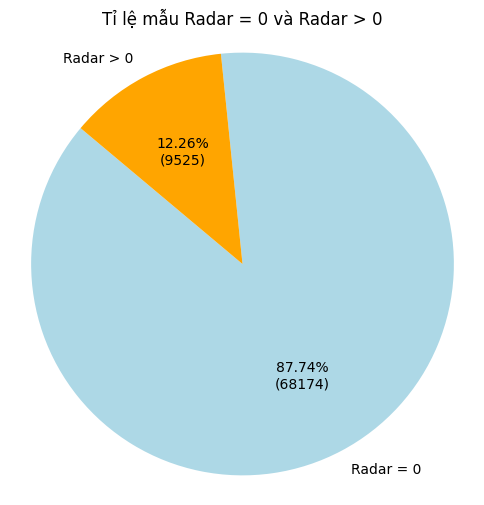

In [13]:
import matplotlib.pyplot as plt

# Dữ liệu
labels = ['Radar = 0', 'Radar > 0']
values = [68174, 9525]
colors = ['lightblue', 'orange']

# Hàm hiển thị phần trăm kèm số lượng
def autopct_format(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{pct:.2f}%\n({absolute})"

# Vẽ biểu đồ tròn
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, colors=colors, 
        autopct=lambda pct: autopct_format(pct, values), startangle=140)
plt.title('Tỉ lệ mẫu Radar = 0 và Radar > 0')
plt.axis('equal')  # Hình tròn đều
plt.show()
